## Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

/Users/anirudhsharma/Desktop/Computer Science/Computer Networks/Computer Network Analysis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
dataset_csv_path = '/Users/anirudhsharma/Desktop/Computer Science/Computer Networks/Computer Network Analysis'
csv_file_names = [
    'archive/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 
    'archive/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'archive/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'archive/Monday-WorkingHours.pcap_ISCX.csv',
    'archive/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'archive/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'archive/Tuesday-WorkingHours.pcap_ISCX.csv',
    'archive/Wednesday-workingHours.pcap_ISCX.csv'
]

In [3]:
complete_paths = [os.path.join(dataset_csv_path, csv_file_name) for csv_file_name in csv_file_names]
df = pd.concat((pd.read_csv(file) for file in complete_paths), ignore_index=True)
df.columns = df.columns.str.strip()  # Remove any leading/trailing whitespace from column names
print("Columns in the dataset:", df.columns)
print("Original Dataset Shape:", df.shape)

Columns in the dataset: Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Cou

In [4]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Visualizing Class Distribution

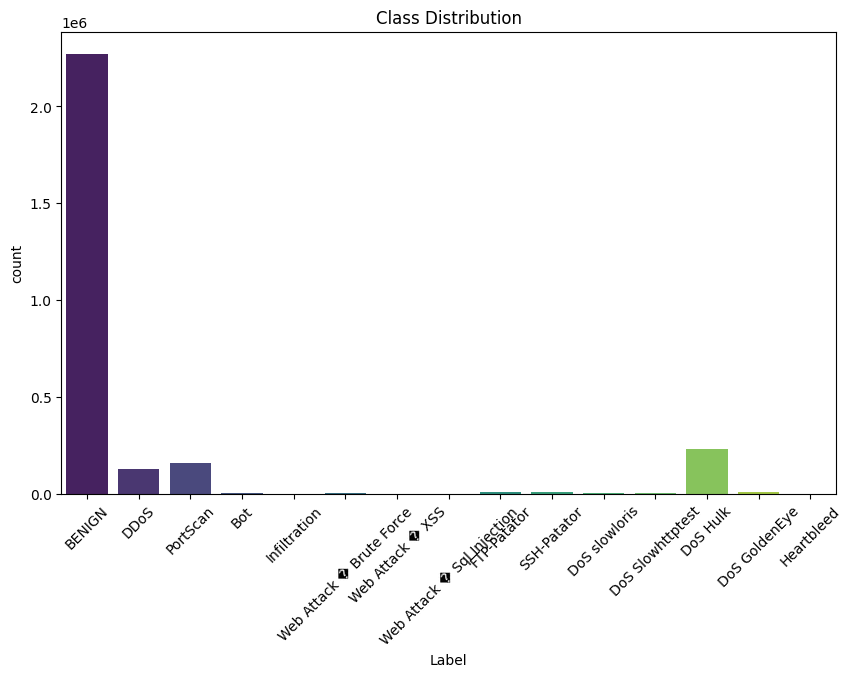

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df, palette='viridis')
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

### Heatmap of Feature Correlations

### Distribution of Important Features

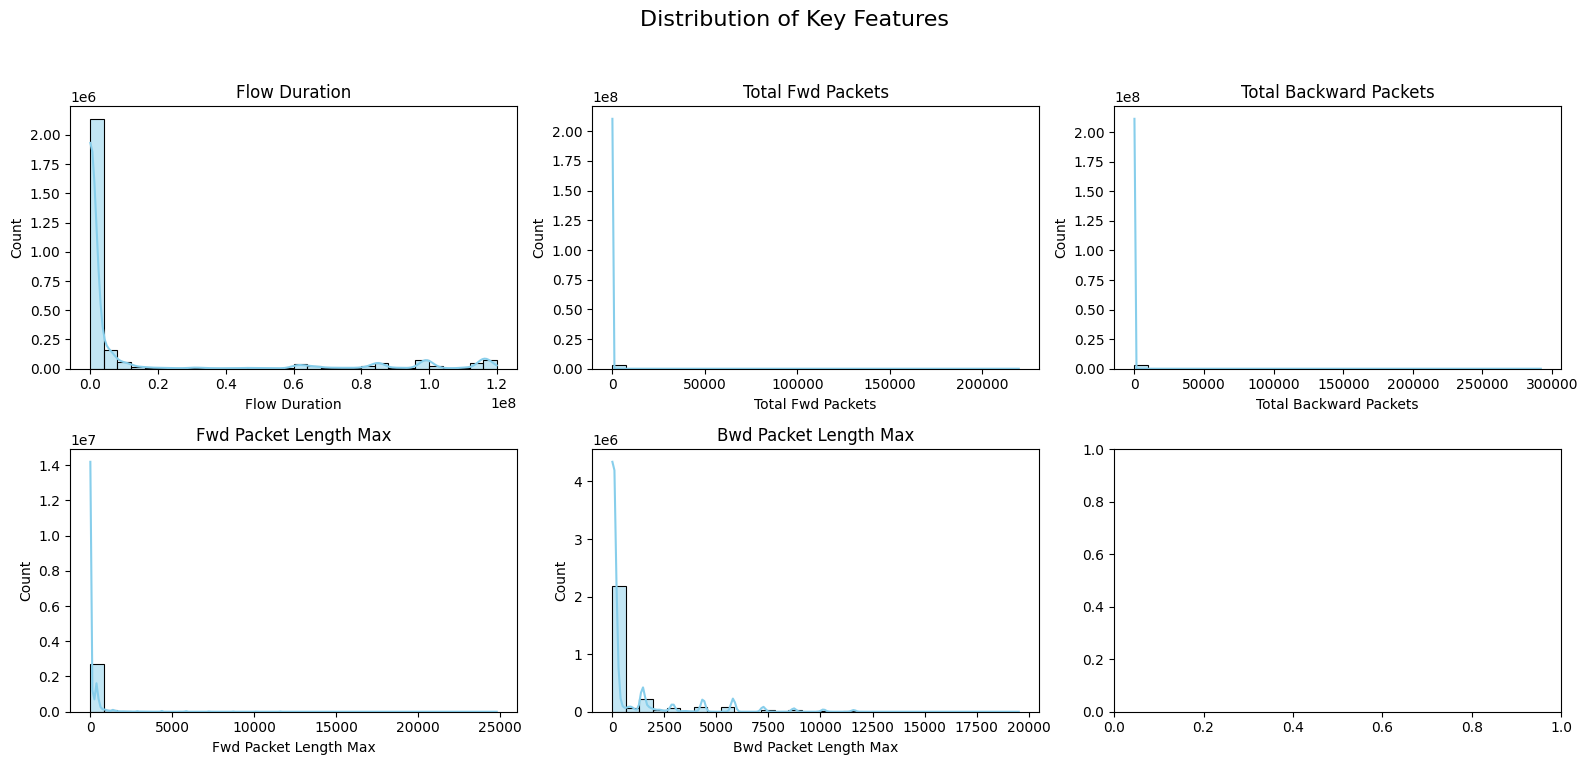

In [6]:
feature_columns = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packet Length Max', 'Bwd Packet Length Max']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
fig.suptitle('Distribution of Key Features', fontsize=16)

for i, feature in enumerate(feature_columns):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i//3, i%3], color='skyblue')
    axes[i//3, i%3].set_title(f'{feature}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Data Processing

## Data Cleaning

In [7]:
df.drop_duplicates(inplace=True)
# Handling Missing Values
df.dropna(inplace=True)

In [8]:
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])

In [9]:
columns_to_keep = [
    'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 
    'Fwd Packet Length Max', 'Bwd Packet Length Max', 'Flow IAT Mean', 
    'Flow IAT Std', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Fwd Header Length', 
    'Bwd Header Length', 'Down/Up Ratio', 'Avg Fwd Segment Size', 
    'Avg Bwd Segment Size', 'Label'
]
df = df[columns_to_keep]

## Normalization

In [10]:
scaler = StandardScaler()
features = scaler.fit_transform(df.drop('Label', axis=1))
labels = df['Label']

## One Hot Encoding

In [11]:
encoder = OneHotEncoder(sparse_output=False)
labels_encoded = encoder.fit_transform(labels.values.reshape(-1, 1))

# Splitting Data

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Exploratory Data Analysis

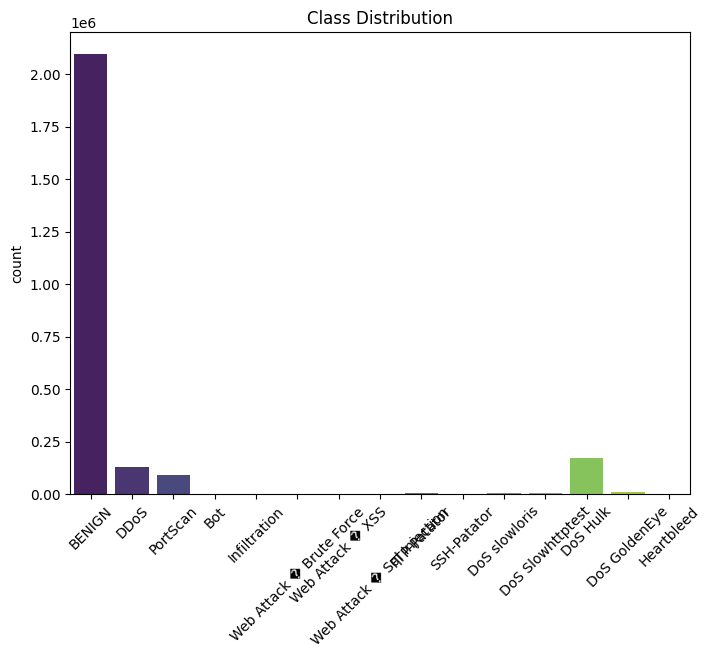

In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x=label_encoder.inverse_transform(df['Label']), palette='viridis')
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

## Correlation HeatMap

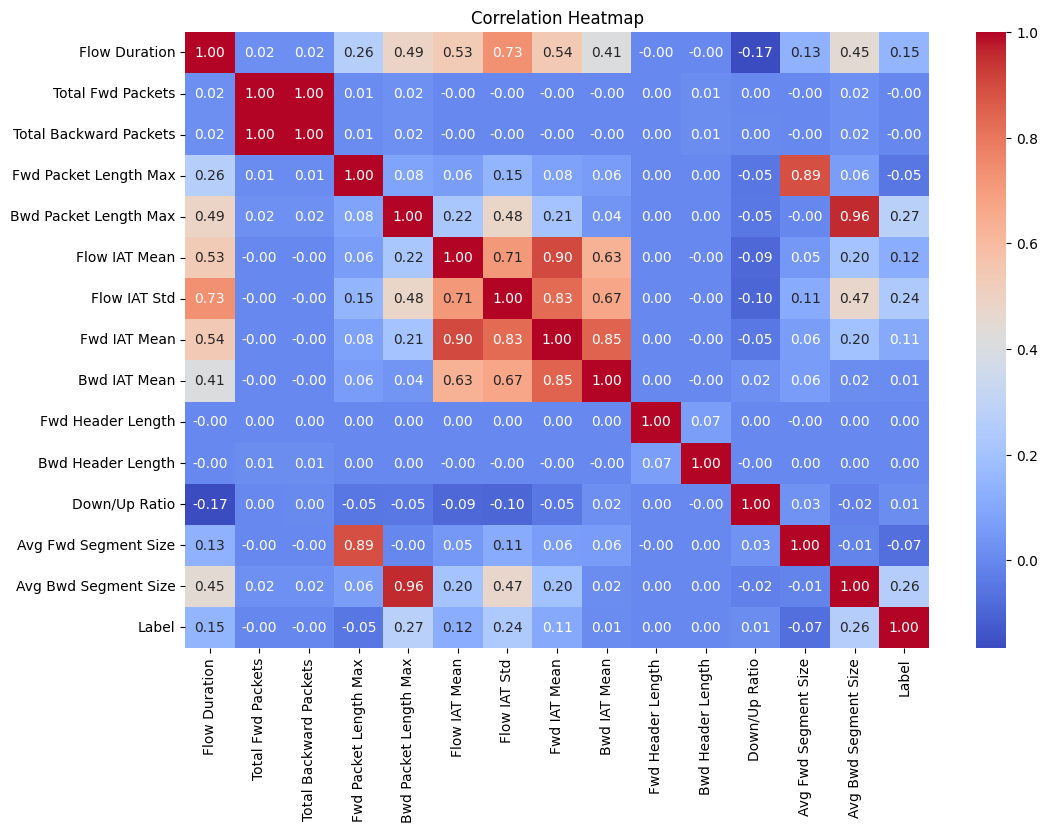

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Model Building

In [15]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(labels_encoded.shape[1], activation='softmax')
])

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Training

In [17]:
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
50441/50441 ━━━━━━━━━━━━━━━━━━━━ 69s 1ms/step - accuracy: 0.9370 - loss: 0.2091 - val_accuracy: 0.9685 - val_loss: 0.0981
Epoch 2/5
50441/50441 ━━━━━━━━━━━━━━━━━━━━ 98s 2ms/step - accuracy: 0.9684 - loss: 0.0944 - val_accuracy: 0.9898 - val_loss: 0.0450
Epoch 3/5
50441/50441 ━━━━━━━━━━━━━━━━━━━━ 71s 1ms/step - accuracy: 0.9812 - loss: 0.0646 - val_accuracy: 0.9902 - val_loss: 0.0450
Epoch 4/5
50441/50441 ━━━━━━━━━━━━━━━━━━━━ 70s 1ms/step - accuracy: 0.9836 - loss: 0.0576 - val_accuracy: 0.9212 - val_loss: 0.2104
Epoch 5/5
50441/50441 ━━━━━━━━━━━━━━━━━━━━ 71s 1ms/step - accuracy: 0.9838 - loss: 0.0569 - val_accuracy: 0.9902 - val_loss: 0.0348


# Model Evaluation

In [18]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

15763/15763 ━━━━━━━━━━━━━━━━━━━━ 5s 340us/step - accuracy: 0.9904 - loss: 0.0339
Test Loss: 0.03426501154899597, Test Accuracy: 0.9903053641319275


In [19]:
predictions = model.predict(X_test)
predicted_labels = predictions.argmax(axis=1)
true_labels = y_test.argmax(axis=1)

15763/15763 ━━━━━━━━━━━━━━━━━━━━ 6s 366us/step


# Classification Report

In [20]:
# Ensure target names are in string format
target_names = [str(label) for label in encoder.categories_[0]]
print(classification_report(true_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    419303
           1       0.77      0.34      0.47       367
           2       0.99      0.99      0.99     25494
           3       0.91      0.90      0.91      2028
           4       0.98      0.95      0.97     34627
           5       0.85      0.95      0.90      1032
           6       0.92      0.92      0.92      1077
           7       0.97      0.98      0.97      1218
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         5
          10       0.98      0.98      0.98     18223
          11       0.99      0.90      0.94       631
          12       0.00      0.00      0.00       250
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00       139

    accuracy                           0.99    504402
   macro avg       0.62      0.59      0.60    504402
weighted avg       0.99   

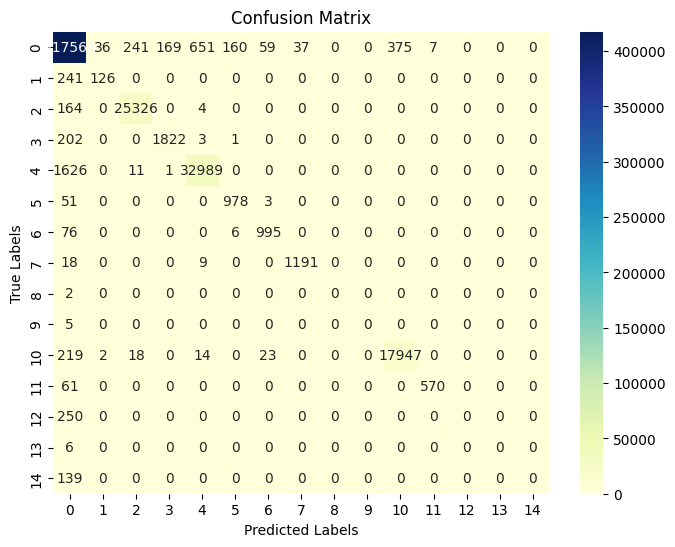

In [21]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Precision-Recall Curve

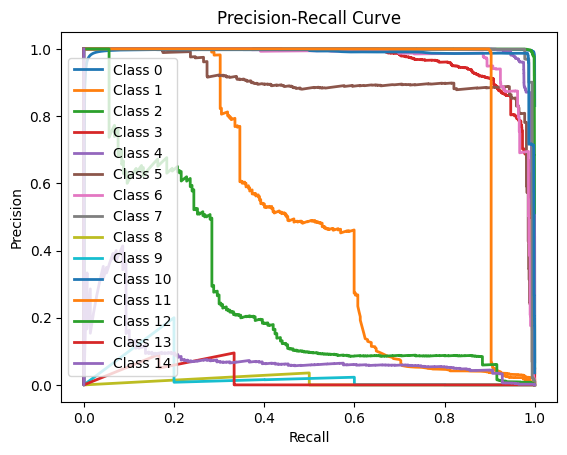

In [22]:
for i in range(labels_encoded.shape[1]):
    precision, recall, _ = precision_recall_curve(y_test[:, i], predictions[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {target_names[i]}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

## ROC Curve

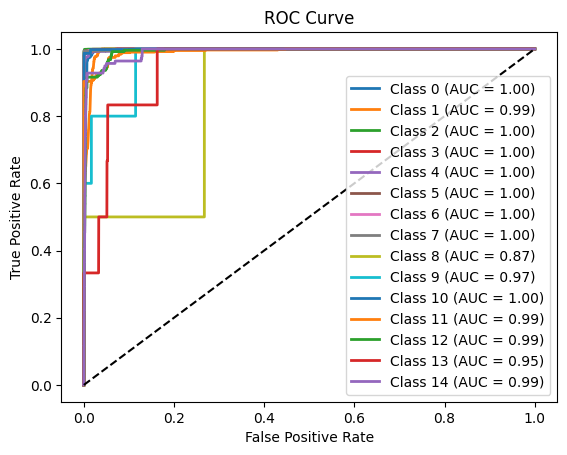

In [23]:
for i in range(labels_encoded.shape[1]):
    fpr, tpr, _ = roc_curve(y_test[:, i], predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {target_names[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

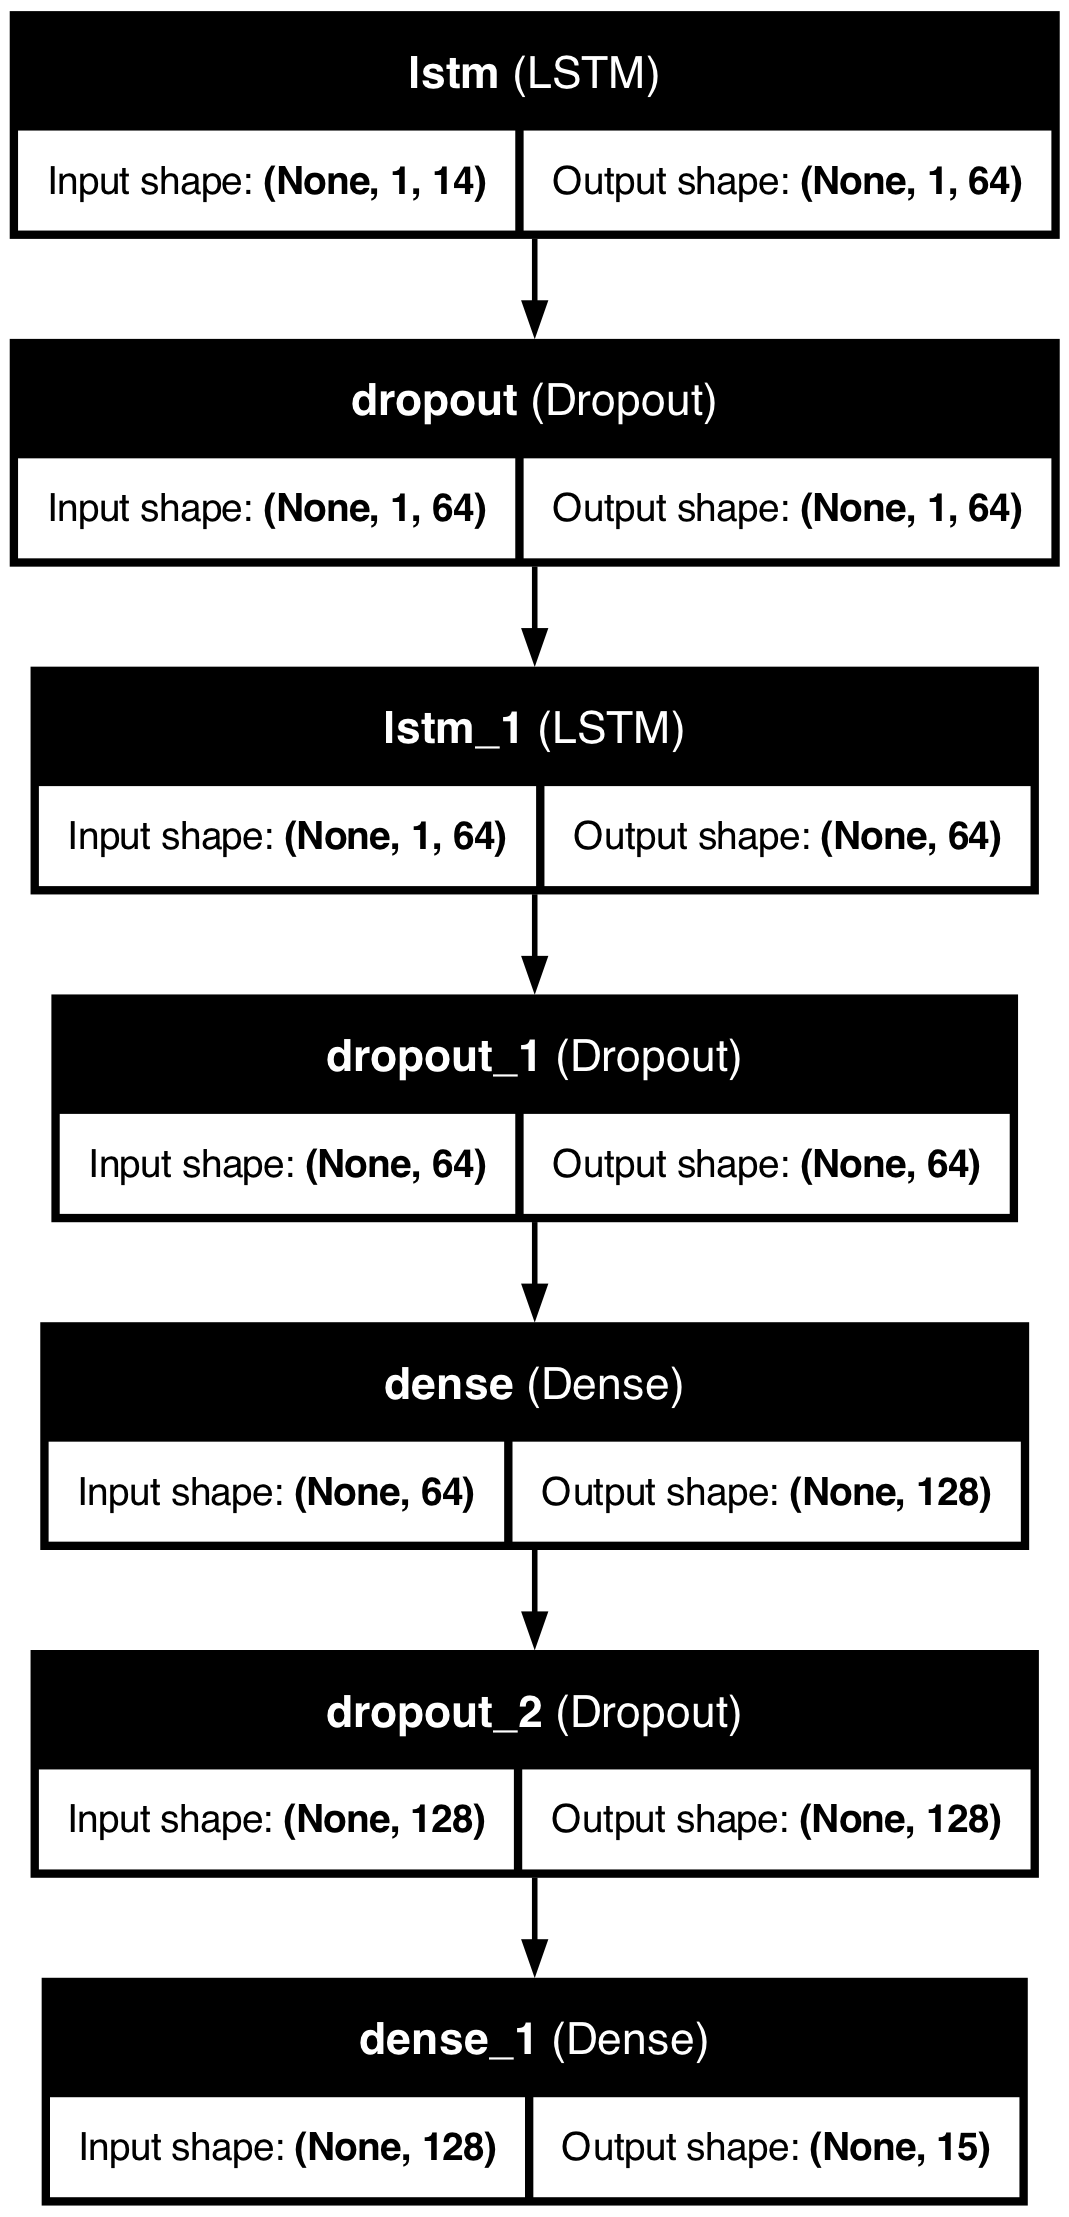

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)